<a href="https://colab.research.google.com/github/SBhoomikaa/Ecg-digitization/blob/main/cropping_cca_deskew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chandra-ocr transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.4/463.4 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 137.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 136.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.33.2
    Uninstalling pydantic_core-2.33.2:
      Successfully uninstalled pydantic_core-2.33.2
  Attempting uninstall: be

In [ ]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.7 MB/s eta 0:00:00


In [ ]:
import cv2
import json
import os
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import drive
import re

# --- MOUNT DRIVE ---
drive.mount('/content/drive')

# --- CONFIG ---
# SINGLE_IMAGE_NAME = "242807775-0003.png"  # Not needed anymore for batch processing
BASE_PROJECT_PATH = "/content/drive/MyDrive/digitization_nnU-net/"
ANNOTATION_DIR = os.path.join(BASE_PROJECT_PATH, "json-anno/")
IMAGE_DIR = os.path.join(BASE_PROJECT_PATH, "images/")
OUTPUT_BASE_DIR = os.path.join(BASE_PROJECT_PATH, "cropped_columns_OCR/")

X_GAP_THRESHOLD = 150

def clean_ocr_text(text):
    if not text:
        return "I"
    text = re.sub(r'[^a-zA-Z0-9\-]', '', text)
    text = text.upper()
    if text:
        text = text.replace('O', '0').replace('l', 'I').replace('|', 'I')
        text = text.strip('-')
        return text if text else "I"
    return "I"

def create_colored_labels(labels, num_labels):
    output = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)
    colors = {}
    for i in range(1, num_labels):
        if i not in colors:
            colors[i] = np.random.randint(0, 255, size=3, dtype=np.uint8)
        output[labels == i] = colors[i]
    return output

def get_box_bounds(pred):
    x_min = int(pred['x'] - pred['width'] / 2)
    y_min = int(pred['y'] - pred['height'] / 2)
    x_max = int(x_min + pred['width'])
    y_max = int(y_min + pred['height'])
    return x_min, y_min, x_max, y_max

def match_predictions_with_ocr(predictions, ocr_results):
    boxes = []
    for idx, pred in enumerate(predictions):
        x_min, y_min, x_max, y_max = get_box_bounds(pred)
        ocr_text = "I"
        if ocr_results and idx < len(ocr_results):
            ocr_output = ocr_results[idx].get('output', '')
            if ocr_output and ocr_output.strip():
                ocr_text = clean_ocr_text(ocr_output)

        box_dict = {
            'pred': pred,
            'x_min': x_min,
            'y_min': y_min,
            'x_max': x_max,
            'y_max': y_max,
            'ocr_text': ocr_text
        }
        boxes.append(box_dict)
        print(f"  Detection {idx}: {ocr_text} at ({x_min}, {y_min})")
    return boxes

def separate_columns_by_left_edge(boxes):
    if not boxes:
        return [], []

    boxes_sorted_by_y = sorted(boxes, key=lambda b: b['y_min'])
    bottom_box = boxes_sorted_by_y[-1]
    main_boxes = [b for b in boxes if b != bottom_box]

    if not main_boxes:
        return [], [bottom_box]

    main_boxes.sort(key=lambda b: b['x_min'])
    columns = []
    current_column = [main_boxes[0]]

    for i in range(1, len(main_boxes)):
        x_gap = main_boxes[i]['x_min'] - main_boxes[i-1]['x_min']
        if x_gap > X_GAP_THRESHOLD:
            columns.append(current_column)
            current_column = [main_boxes[i]]
        else:
            current_column.append(main_boxes[i])

    columns.append(current_column)
    print(f"Found {len(columns)} main columns + 1 bottom row")
    return columns, [bottom_box]

def process_lead_region(cropped_img, box, box_idx, base_name, col_name, image_output_dir):
    img_h, img_w = cropped_img.shape[:2]

    # Bottom row is always II
    if col_name == "bottom_row":
        lead_label = "II"
    else:
        lead_label = box.get('ocr_text', 'I')

    y_center = box['y_min'] + (box['y_max'] - box['y_min']) // 2
    if col_name != "bottom row":
        region_y1 = max(0, y_center - 240)
        region_y2 = min(img_h, y_center + 200)
    signal_region = cropped_img[region_y1:region_y2, :]

    if signal_region.size == 0:
        print(f"  Warning: Empty signal region for box {box_idx}")
        return lead_label

    red_channel = signal_region[:, :, 2]
    normalized_red = red_channel / 255.0
    threshold = 0.75
    binary_image = (normalized_red < threshold).astype(np.uint8) * 255

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    component_count = num_labels - 1
    print(f"  Lead {box_idx} ({lead_label}): Found {component_count} components")

    if num_labels > 1:
        areas = stats[1:, cv2.CC_STAT_AREA]
        largest_component_idx = np.argmax(areas) + 1
        largest_area = areas[largest_component_idx - 1]
        print(f"  Largest component: Label {largest_component_idx}, Area: {largest_area} pixels")

        largest_component_mask = (labels == largest_component_idx).astype(np.uint8)
        mask_to_remove = binary_image.copy()
        mask_to_remove[largest_component_mask > 0] = 0
        masked_region = signal_region.copy()
        masked_region[mask_to_remove > 0] = [255, 255, 255]

        # ONLY save cleaned image
        cleaned_filename = f"{base_name}_{lead_label}_cleaned.png"
        cleaned_path = os.path.join(image_output_dir, cleaned_filename)
        cv2.imwrite(cleaned_path, masked_region)
        print(f"  Saved: {cleaned_filename}")
    else:
        print(f"  Warning: No components found")

    return lead_label

# --- MAIN ---
# Get all JSON files in the annotation directory
json_files = [f for f in os.listdir(ANNOTATION_DIR) if f.endswith('.json')]
print(f"Found {len(json_files)} JSON files to process")

for json_file in json_files:
    base_name = os.path.splitext(json_file)[0]
    image_name = base_name + ".png"

    image_output_dir = os.path.join(OUTPUT_BASE_DIR, base_name)
    os.makedirs(image_output_dir, exist_ok=True)

    image_path = os.path.join(IMAGE_DIR, image_name)
    json_path = os.path.join(ANNOTATION_DIR, json_file)

    if not os.path.exists(image_path):
        print(f"\nSkipping {json_file}: Image not found at {image_path}")
        continue

    print(f"\n{'='*60}")
    print(f"Processing: {image_name}")
    print(f"Output directory: {image_output_dir}")
    print(f"{'='*60}")

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        continue

    img_h, img_w = img.shape[:2]

    with open(json_path) as f:
        data = json.load(f)

    if isinstance(data, list) and len(data) > 0:
        data = data[0]

    detections_data = data.get('detections', {})
    predictions = detections_data.get('predictions', [])
    ocr_results = data.get('ocr_by_detection', [])

    print(f"Found {len(predictions)} predictions and {len(ocr_results)} OCR results")

    boxes_with_ocr = match_predictions_with_ocr(predictions, ocr_results)
    columns, bottom_row = separate_columns_by_left_edge(boxes_with_ocr)

    # Process main columns
    for col_idx, column_boxes in enumerate(columns):
        print(f"\n--- Column {col_idx + 1} ---")
        col_left = min(b['x_min'] for b in column_boxes)

        if col_idx < len(columns) - 1:
            next_col_left = min(b['x_min'] for b in columns[col_idx + 1])
            col_right = next_col_left
        else:
            col_right = img_w

        crop_x1 = max(0, col_left)
        crop_x2 = min(img_w, col_right)
        crop_y1 = 0
        crop_y2 = img_h

        print(f"Column spans x=[{crop_x1}, {crop_x2}]")
        cropped = img[crop_y1:crop_y2, crop_x1:crop_x2]

        if cropped.size > 0:
            print(f"Processing leads in column {col_idx + 1}...")
            for box_idx, box in enumerate(column_boxes):
                adjusted_box = {
                    'x_min': box['x_min'] - crop_x1,
                    'y_min': box['y_min'] - crop_y1,
                    'x_max': box['x_max'] - crop_x1,
                    'y_max': box['y_max'] - crop_y1,
                    'ocr_text': box['ocr_text']
                }
                process_lead_region(cropped, adjusted_box, box_idx + 1,
                                  base_name, f"col{col_idx + 1}", image_output_dir)

    # Process bottom row
    if bottom_row:
        print(f"\n--- Bottom Row ---")
        bottom_box = bottom_row[0]

        # Crop full width, from top of bottom box to bottom of image
        crop_x1 = 0
        crop_x2 = img_w
        crop_y1 = bottom_box['y_min']-300
        crop_y2 = img_h

        crop_y1 = max(0, crop_y1)

        print(f"Bottom row spans x=[{crop_x1}, {crop_x2}], y=[{crop_y1}, {crop_y2}]")
        cropped_bottom = img[crop_y1:crop_y2, crop_x1:crop_x2]

        if cropped_bottom.size > 0:
            output_filename = f"{base_name}_bottom_row.png"
            output_path = os.path.join(image_output_dir, output_filename)
            cv2.imwrite(output_path, cropped_bottom)
            print(f"Saved: {output_filename} - Size: {cropped_bottom.shape}")

            # Adjust bottom box coordinates to cropped image space
            adjusted_bottom_box = {
                'x_min': bottom_box['x_min'] - crop_x1,
                'y_min': bottom_box['y_min'] - crop_y1,
                'x_max': bottom_box['x_max'] - crop_x1,
                'y_max': bottom_box['y_max'] - crop_y1,
                'ocr_text': bottom_box['ocr_text']
            }

            print(f"Processing bottom row lead...")
            process_lead_region(cropped_bottom, adjusted_bottom_box, 1,
                              base_name, "bottom_row", image_output_dir)

    print(f"\nCompleted processing: {image_name}")

print(f"\n{'='*60}")
print(f"ALL DONE! Processed {len(json_files)} images")
print(f"Output saved to: {OUTPUT_BASE_DIR}")
print(f"{'='*60}")

Streaming output truncated to the last 5000 lines.
  Detection 3: V4 at (1545, 710)
  Detection 4: V5 at (1547, 983)
  Detection 5: V1 at (1075, 711)
  Detection 6: V6 at (1545, 1253)
  Detection 7: V3 at (1078, 1253)
  Detection 8: II at (141, 1253)
  Detection 9: II at (141, 983)
  Detection 10: V2 at (1078, 981)
  Detection 11: II at (141, 1509)
  Detection 12: I at (140, 710)
Found 4 main columns + 1 bottom row

--- Column 1 ---
Column spans x=[140, 608]
Processing leads in column 1...
  Lead 1 (I): Found 174 components
  Largest component: Label 63, Area: 2501 pixels
  Saved: 987816877-0003_I_cleaned.png
  Lead 2 (II): Found 173 components
  Largest component: Label 53, Area: 3127 pixels
  Saved: 987816877-0003_II_cleaned.png
  Lead 3 (II): Found 186 components
  Largest component: Label 24, Area: 3207 pixels
  Saved: 987816877-0003_II_cleaned.png

--- Column 2 ---
Column spans x=[608, 1075]
Processing leads in column 2...
  Lead 1 (AVF): Found 125 components
  Largest component: 

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading test image: /content/drive/MyDrive/digitization_nnU-net/cropped_columns_OCR/261884655-0003/261884655-0003_V3_cleaned.png

--- Original Image ---


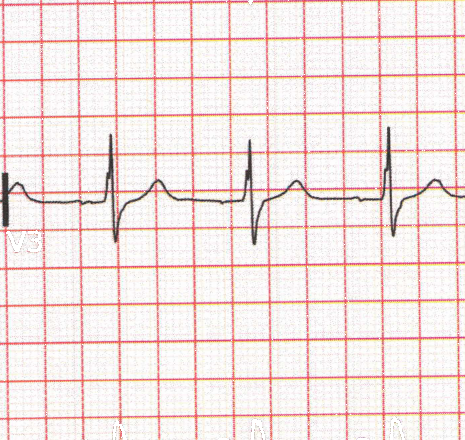

  > Detected 43 horizontal grid lines. Median angle: -0.8905 degrees

--- Unskewed Image (Corrected by 0.8905 degrees) ---


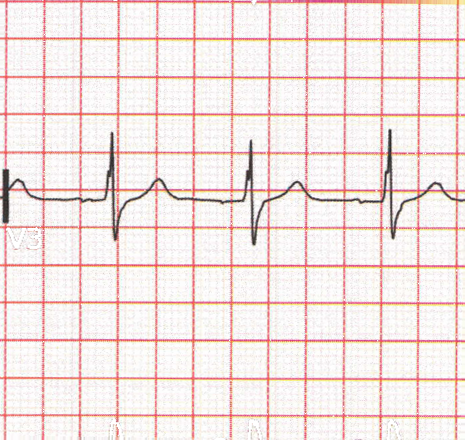

In [ ]:
import cv2
import numpy as np
import os
from google.colab import drive
from google.colab.patches import cv2_imshow

# --- 1. MOUNT DRIVE ---
print("Mounting Google Drive...")
drive.mount('/content/drive')

# --- 2. 🔔 CONFIGURATION: SET YOUR IMAGE PATH & PARAMETERS ---

# ❗❗ SET THIS TO THE FULL PATH of the one image you want to test
TEST_IMAGE_PATH = "/content/drive/MyDrive/digitization_nnU-net/cropped_columns_OCR/261884655-0003/261884655-0003_V3_cleaned.png"

# --- Tune these parameters if the rotation is wrong ---
HOUGH_THRESHOLD = 100   # How many points to form a line (lower for fainter grids)
HOUGH_MIN_LENGTH = 100  # Minimum length of a grid line
HOUGH_MAX_GAP = 20      # How big a gap in a line to still count it
# ---

# --- 3. HELPER FUNCTION: HOUGH TRANSFORM UNSKEW (Safer Version) ---

def unskew_image_safe(image, hough_thresh, min_len, max_gap):
    """
    Detects the skew of the image by ONLY looking at near-horizontal grid lines.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Use Hough transform to find all straight lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180,
                            threshold=hough_thresh,
                            minLineLength=min_len,
                            maxLineGap=max_gap)

    angles = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.rad2deg(np.arctan2(y2 - y1, x2 - x1))

            # --- THIS IS THE KEY CHANGE ---
            # We ONLY look for near-horizontal lines (the grid)
            # and we IGNORE all vertical lines completely.
            if abs(angle) < 10: # Only accept lines skewed less than 10 degrees
                angles.append(angle)

    if not angles:
        print("  > Warning: No horizontal grid lines found. No rotation will be applied.")
        return image, 0.0 # No rotation

    # Get the median angle of all found grid lines
    median_angle = np.median(angles)

    print(f"  > Detected {len(angles)} horizontal grid lines. Median angle: {median_angle:.4f} degrees")

    # If the angle is tiny, don't rotate
    if abs(median_angle) < 0.1: # Increased threshold for "straight"
        print("  > Angle is negligible (< 0.1 deg). No rotation needed.")
        return image, median_angle

    # Rotate the image to correct the skew
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)

    return rotated, median_angle

# --- 4. MAIN SCRIPT ---

print(f"Loading test image: {TEST_IMAGE_PATH}")
if not os.path.exists(TEST_IMAGE_PATH):
    print(f"--- ❗ ERROR: FILE NOT FOUND ---")
    print(f"Could not find image at the path specified.")
    print("Please double-check the 'TEST_IMAGE_PATH' variable.")
else:
    image = cv2.imread(TEST_IMAGE_PATH)
    if image is None:
        print("--- ❗ ERROR: IMAGE FAILED TO LOAD ---")
    else:
        print("\n--- Original Image ---")
        cv2_imshow(image)

        # Run the NEW, SAFER unskewing function
        unskewed_img, angle = unskew_image_safe(image,
                                                HOUGH_THRESHOLD,
                                                HOUGH_MIN_LENGTH,
                                                HOUGH_MAX_GAP)

        print(f"\n--- Unskewed Image (Corrected by {-angle:.4f} degrees) ---")
        cv2_imshow(unskewed_img)